# Magnetically Modelling MagSafe - magpylib

This is the code referred to in my blog post ->  https://kavi.sblmnl.co.za/magnetically-modelling-magsafe/

###Initial Setup

Install the magpylib package first (You may be asked to restart the runtime)

In [1]:
!pip install magpylib==4.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.1/171.1 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for magpylib: filename=magpylib-4.1.1-py3-none-any.whl size=203560 sha256=7c934d62eefeeec8b84985a7ee5351cd4ebb1456f32cbcb39aa6a627aab54b61
  Stored in directory: /root/.cache/pip/wheels/b9/73/c9/71a761692ed1aff6da31ab551a6c9e8f1a59b3400d9e8f381b
Successfully built magpylib


Import packages + Set up color scheme

In [2]:
#Importing Packages
import numpy as np
import matplotlib.pyplot as plt
import magpylib as magpy
import plotly.graph_objects as go
from magpylib.magnet import CylinderSegment

#Defines the color scheme (matches the convention in https://kavi.sblmnl.co.za/magsafe-on-iphone/)
user_defined_style = {
    'show': True,
    'color': {
        'transition': 1,
        'mode': 'tricolor',
        'middle': 'white',
        'north': 'blue',
        'south': 'red',
    },
}
magpy.defaults.display.style.magnet.magnetization = user_defined_style

###Single MagSafe Array

Create a single MagSafe array (and plot it)

In [3]:
# Physical measurements (Release R21, p159/159 of this (ADG): https://developer.apple.com/accessories/Accessory-Design-Guidelines.pdf)
# A single MagSafe Array is made of two oppositely magnetized "rings" of magnets, called "inner" and "outer"
# The "clocking magnet"/alignment magnet is not included

inner_r1 = 23     #mm
inner_r2 = 24.15  #mm
outer_r1 = 25.9   #mm
outer_r2 = 27.05  #mm
thickness = 0.55  #mm

magnetic_field_strength = 1370  #mT      #Page 157 of ADG - 13.7kGs (minimum) Ref: https://en.wikipedia.org/wiki/Gauss_(unit)

# Each magnet "ring" is made of a CylinderSegment (Ref here https://magpylib.readthedocs.io/en/stable/_autogen/magpylib.magnet.html?highlight=CylinderSegment#magpylib.magnet.CylinderSegment)
# Creating the inner and outer rings

outer_ring = CylinderSegment(magnetization=(0,0,magnetic_field_strength),
                         dimension=(outer_r1,outer_r2,thickness,0,360),
                         position=(0,0,0))

inner_ring = CylinderSegment(magnetization=(0,0,-1*magnetic_field_strength),
                         dimension=(inner_r1,inner_r2,thickness,0,360),
                         position=(0,0,0))

# Creating a Collection that allows both rings to be manipulated as a single object
magsafe_array = outer_ring + inner_ring

# setup plotly figure and plotting magsafe_array
fig = go.Figure()
fig.update_layout(
    #autosize=False,
    width=800,
    height=400)

magpy.show(magsafe_array, canvas=fig, backend='plotly')

fig.show()

###More Magnet Arrays

Create two arrays, move them and plot the magnetic field at a specific point

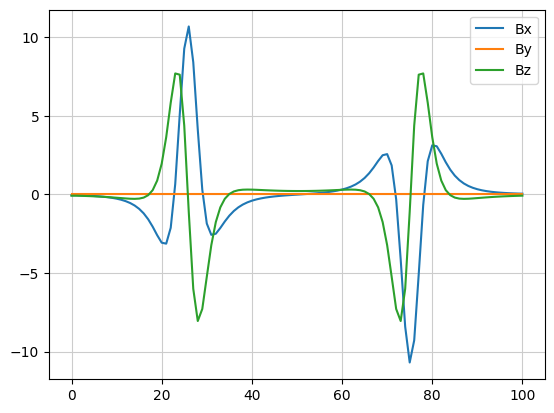

In [4]:
sensor = magpy.Sensor(position=(0,0,0))

offset_between_rings = -100 #mm difference in starting position in x-dimension
distance_between_rings = 10 #mm distance between rings in z-dimension

x_path = np.linspace((0,0,0), (100,0,0), 100)

magsafe_array1 = magsafe_array.copy(position=(offset_between_rings/2.,0,distance_between_rings/2.))
magsafe_array1.move(x_path)

magsafe_array2 = magsafe_array.copy(position=(-1*offset_between_rings/2.,0,-1*distance_between_rings/2.))
magsafe_array2.move(-1*x_path)

system = magsafe_array1 + magsafe_array2

magpy.show(system, sensor, backend='plotly',animation=2)

B = sensor.getB(system, sumup=True)

plt.plot(B, label=['Bx', 'By', 'Bz'])
plt.legend()
plt.grid(color='.8')
plt.show()

###Magnetic Field Visualization

Matplotlib Streamplot 2D slice based on https://magpylib.readthedocs.io/en/latest/_pages/gallery/gallery_vis_mpl_streamplot.html

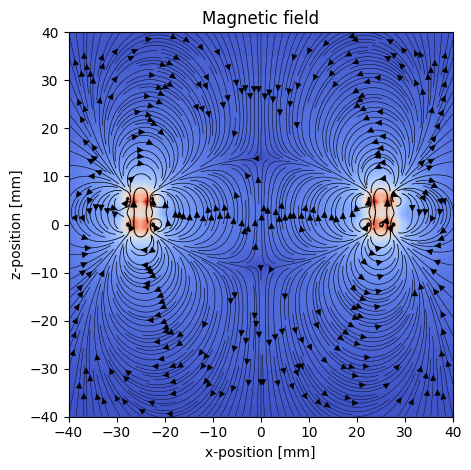

In [5]:
import matplotlib.pyplot as plt

#fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(20,5))

fig, ax1 = plt.subplots()

# create grid
# play with xlim and zlim below to "zoom" in and out of plot
# xlim = np.linspace(20, 40, 60) #plotting limits x-axis (x_min,x_max,x_number_of_samples)
# zlim = np.linspace(-5, 10, 60) #plotting limits z-axis (z_min,z_max,z_number_of_samples)

# Values used for gif
#xlim = np.linspace(20, 40, 60)
#zlim = np.linspace(-5, 10, 60)

# Values used for screenshot in blog post
xlim = np.linspace(-40, 40, 60)
zlim = np.linspace(-40, 40, 60)


grid = np.array([[(x,0,z) for x in xlim] for z in zlim])

# compute and plot field of coil1

magsafe_array3 = magsafe_array.copy()

# play with position below to offset one array from another (x_axis,leave_at_zero,z_axis) -> (left_right,0,up_down)

magsafe_array4 = magsafe_array.copy(position=(0,0,5))

magsafe_system = magsafe_array3 + magsafe_array4

B = magpy.getB(magsafe_system, grid)
Bamp = np.linalg.norm(B, axis=2)
Bamp /= np.amax(Bamp)

Bamp = np.power(Bamp,(1./4.)) #added

sp = ax1.contourf(
    grid[:,:,0], grid[:,:,2], Bamp,
    levels=100,
    cmap='coolwarm',)

sp = ax1.streamplot(
    grid[:,:,0], grid[:,:,2], B[:,:,0], B[:,:,2],
    #density=0.8, # Value used for gif in blog post
    density=3.5, # Value used for screenshot in blog post
    color='black',
    #linewidth=np.sqrt(Bamp)*3,
    linewidth=np.sqrt(Bamp),
    cmap='coolwarm',
    #broken_streamlines=False #comment out for screenshot
)


# figure styling
ax1.set(
    title='Magnetic field',
    xlabel='x-position [mm]',
    ylabel='z-position [mm]',
    aspect=1,
)

plt.tight_layout()
plt.show()